#Aprendizado não-supervisionado - Projeto final

link para o notebook: https://colab.research.google.com/drive/1YkIposeZvgF_fejX8_pgo7fJS9aOqnm_?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric
from scipy.spatial.distance import euclidean
from google.colab import drive
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análise de dados

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
data.shape

(167, 10)

Como podemos ver, há 10 variáveis para 167 países, então é possível que tentemos utilizar uma matriz de correlação para verificar o quão correlacionados estão os dados (linearmente, por Pearson). Além disso, é importante verificar as estatístcas para analisar a possível necessidade de uma normalização

In [ ]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


As estatísticas mostram que os valores mínimos e máximos das variáveis possuem uma grande diferença de ordem entre si. Isso se dá porquê estas são medidas em unidades e contagens diferentes, e é necessário posteriormente padronizar as medidas para uma comparação justa. Os boxplots mostram qualitativamente melhor este fenômeno

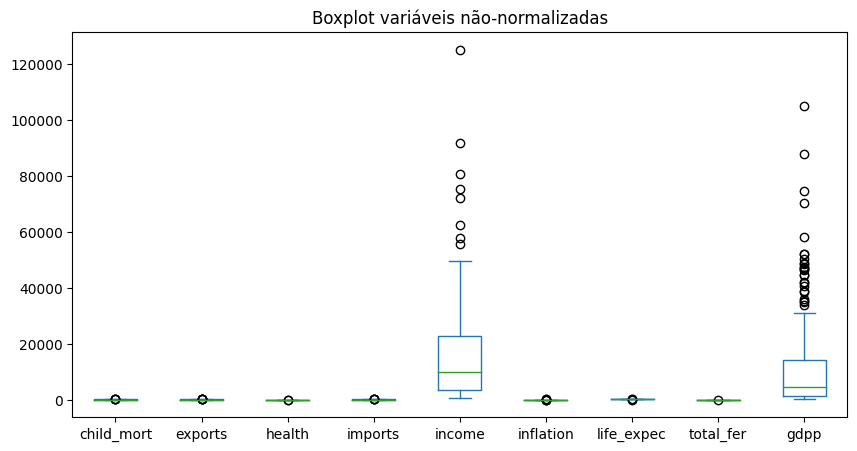

In [ ]:
fig, ax = plt.subplots()
data.plot(kind='box', ax=ax, figsize=(10,5))
ax.set_title('Boxplot variáveis não-normalizadas')
fig.show()

A dsitribuição para as variáveis income e gdpp possuem valores máximos e mínimos bem distantes dos das outras variáveis. É improtante lembrar que não estamos usando a variável country no boxplot porquê é totalmente categórica e assim não conseguimos diretamente estabelecer as estatísticas de mediana/max/min no boxplot

Para padronização de dados, fazemos a normalização

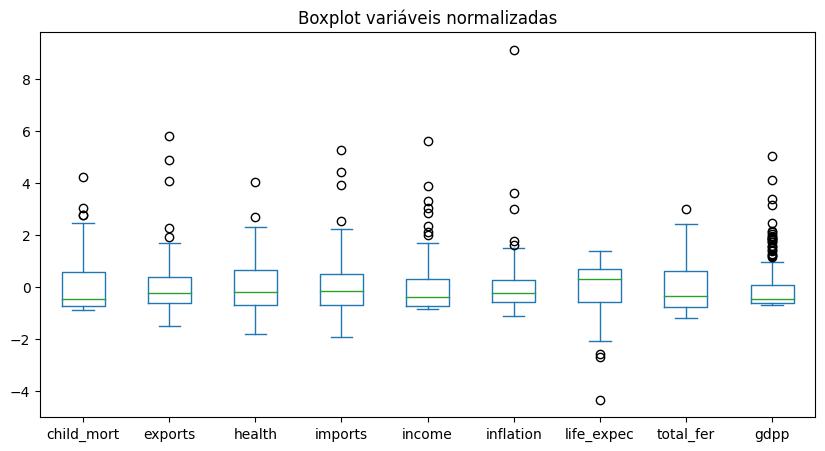

In [ ]:
data.set_index('country', inplace=True)
scaler = StandardScaler()
data_normal = pd.DataFrame(scaler.fit_transform(data),index=data.index,columns=data.columns)

fig, ax = plt.subplots()
data_normal.plot(kind='box', ax=ax, figsize=(10,5))
ax.set_title('Boxplot variáveis normalizadas')
fig.show()

Agora é possível ver que as variáveis estão na mesma faixa, apesar de apresentarem alguns possíveis outliers. Podemos também pensar em algumas das faixas como uma distribuição log-normal

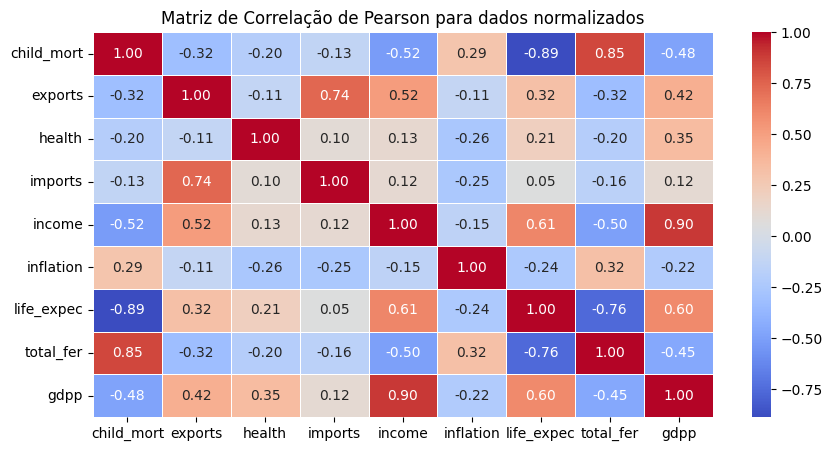

In [ ]:
matriz_correlacao = data_normal.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação de Pearson para dados normalizados')
plt.show()

Na correlação de Pearson, dados linearmente correlacionados possuem coeficientes de +1 até -1, em que 0 significa não haver uma aparente correlação linear, e +1 e -1 haver correlação positiva ou negativa. É possível verificar que os dados são relativamente bem correlacionados entre si, como por exemplo gdpp e income, total_fer e child_mort, e life_expec e child_mort. A diagonal é toda +1 pois representa a correlação da variável com ela mesma. Isso indica um certo agrupamento para os clusters

A distância euclidiana (visto que as variáveis possuem uma distância entre si vetorialmente falando) nos auxlia a encontrar o número N de clusters com o método do cotovelo

In [ ]:
euclidean = DistanceMetric.get_metric('euclidean')

distances = euclidean.pairwise(data_normal)
distances = pd.DataFrame(distances,index=data_normal.index,columns=data_normal.index)

distances.head()

country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,4.143346,3.897552,2.999646,4.413445,4.182032,4.005488,5.806289,6.010840,3.903319,...,6.092519,5.299481,6.829447,4.190126,3.333474,2.883648,5.355316,4.519092,2.497527,1.491133
Albania,4.143346,0.000000,1.841745,5.014206,1.124893,2.288455,0.973849,3.492903,3.508274,2.053935,...,3.802419,2.776056,5.450056,1.336680,1.832387,2.176048,4.258500,2.267017,3.155440,4.251900
Algeria,3.897552,1.841745,0.000000,3.877263,2.116296,1.898002,1.517081,3.933867,4.280725,1.483713,...,3.587995,3.456959,6.209123,2.094995,1.266131,2.327822,2.993890,2.731247,1.978736,3.611309
Angola,2.999646,5.014206,3.877263,0.000000,4.980289,4.922961,4.674398,6.660395,6.770665,3.996854,...,5.591360,6.259880,8.364089,5.249095,3.835555,3.607064,4.913815,4.605136,2.526002,2.210967
Antigua and Barbuda,4.413445,1.124893,2.116296,4.980289,0.000000,2.854338,1.668965,3.283559,3.022640,2.328978,...,2.979604,2.571279,5.469989,1.805602,2.467714,2.142365,4.626691,2.013791,3.470501,4.436652


o k ótimo deveria ser representado quando a curva começa a formar um cotovelo, como podemos ver abaixo podemos escolher 4 como o ótimo

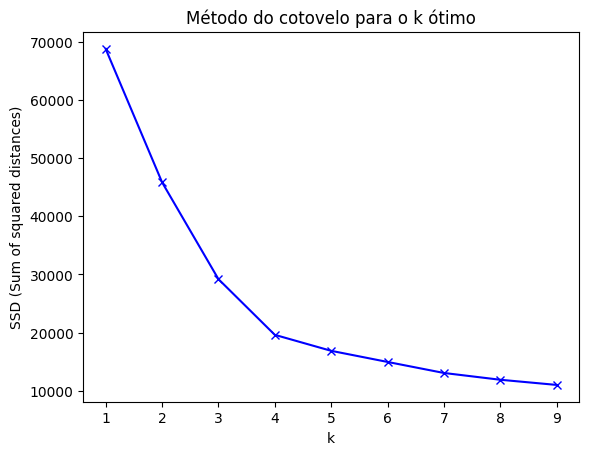

In [ ]:
sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(distances)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSD (Sum of squared distances)')
plt.title('Método do cotovelo para o k ótimo')
plt.show()

##KMeans

O algoritmo K-means é um método de agrupamento de variáveis para particionar um conjunto de dados em clusters, com base em características similares.

O K-means é um algoritmo iterativo e busca otimizar a alocação de pontos de dados em clusters de modo que a soma das distâncias quadráticas entre os pontos e seus centroides seja minimizada. Cada cluster é representado por um centroide, que é o ponto médio de todos os pontos no cluster.

Inicialmente, K centroides são alocados aleatoriamente no espaço de features e então cada ponto de dados é atribuído ao cluster cujo centroide é o mais próximo (distância euclidiana).

Assim, Os centroides de cada cluster são recalculados como a média dos pontos pertencentes a esse cluster, para então ser feito o processo iterativo.

A atualização é repetida iterativamente até que os centroides não se movam de maneira significativa ou um número máximo de iterações seja atingido.

Assim cada ponto do conjunto de dados pertencerá a um dos clusters.

O algoritmo possui algumas limitações, como sensibilidade à inicialização dos centroides, especificação do número de clusters e a suposição de que os clusters têm formas esféricas e tamanhos aproximadamente iguais. Nos cenários onde isto não ocorre, pode ser interessante utilizar outros algoritmos como DBSCAN.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(data_normal)
clusters = kmeans.predict(data_normal)
cluster_df = data_normal.copy()
cluster_df['cluster'] = clusters

cluster_df.head(7)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,1
Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,0
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,1
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,0
Argentina,-0.591177,-0.812628,0.468966,-1.279787,0.080920,1.244725,0.591474,-0.382933,-0.145791,0
Armenia,-0.501643,-0.743107,-0.882089,-0.065883,-0.543421,-0.001123,0.309514,-0.833471,-0.533233,0


Agora com o kmeans podemos ver a qual cluster pertence cada país, e também podemos calcular quantos países há em cada cluster.

In [ ]:
cluster_df.cluster.value_counts().sort_index()

0    88
1    46
2    30
3     3
Name: cluster, dtype: int64

Podemos ver que há apenas 3 países no cluster 3, então talvez seja uma boa alternativa reduzir o número de clusters para 3 e fazer um agrupamento melhor distribuído

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_normal)
clusters = kmeans.predict(data_normal)
cluster_df = data_normal.copy()
cluster_df['cluster'] = clusters

cluster_df.head(7)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,0
Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,1
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,1
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,0
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,1
Argentina,-0.591177,-0.812628,0.468966,-1.279787,0.080920,1.244725,0.591474,-0.382933,-0.145791,1
Armenia,-0.501643,-0.743107,-0.882089,-0.065883,-0.543421,-0.001123,0.309514,-0.833471,-0.533233,1


In [ ]:
cluster_df.cluster.value_counts().sort_index()

0    47
1    84
2    36
Name: cluster, dtype: int64

Agora há uma melhor distribuição deles nos clusters, apesar disso trazer a desvantagem de não tornar os clusters tão específicos assim, dependendo da quantidade de dados e características. Também podemos identificar qual país representa melhor cada cluster a partir da menor distância ao centro do cluster

In [ ]:
def get_distance(cluster, dist):
    return euclidean(cluster, dist)

for idx, cluster_center in enumerate(kmeans.cluster_centers_):
    cluster = cluster_center
    country_indices = data_normal[cluster_df.cluster == idx].index
    distances = data_normal.loc[country_indices].apply(lambda row: get_distance(cluster, row), axis=1)
    closest_country_index = distances.idxmin()

    print(f"O país que melhor representa o cluster {idx} é : {closest_country_index} (dist: {distances[closest_country_index]:.2f}).")
    print("------------------------------------------------------------")
    print()

O país que melhor representa o cluster 0 é : Guinea (dist: 0.83).
------------------------------------------------------------

O país que melhor representa o cluster 1 é : Jamaica (dist: 0.73).
------------------------------------------------------------

O país que melhor representa o cluster 2 é : Iceland (dist: 0.73).
------------------------------------------------------------



<function matplotlib.pyplot.show(close=None, block=None)>

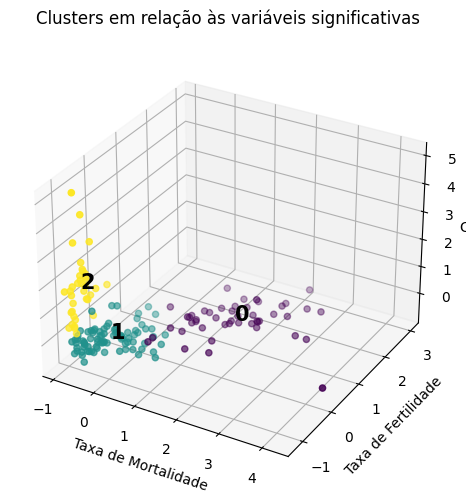

In [ ]:
centers = kmeans.cluster_centers_
centers.shape
cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig = plt.figure(figsize=(10,5))
plt.suptitle("Clusters em relação às variáveis significativas")
ax = plt.axes(projection='3d')
ax.set_xlabel("Taxa de Mortalidade")
ax.set_ylabel("Taxa de Fertilidade")
ax.set_zlabel("GDPP")
ax.scatter3D(cluster_df.child_mort,
             cluster_df.total_fer,
             cluster_df.gdpp,
             c = cluster_df.cluster)
for j in range(3):
    ax.text(centers[j, cols.index('child_mort')],
            centers[j, cols.index('total_fer')],
            centers[j, cols.index('gdpp')],
            c='black', s=j, fontsize=15, fontweight=700)
plt.tight_layout()
plt.show

O Cluster 0 possui maior taxa de fertilidade mortalidade, portanto é caracterizado por países subdesenvolvidos, como representado nas distâncias euclidianos pela Gunné. Já o 1 representa países que estão em progresso de desenvolvimento, e o 2 países desenvolvidos com baixas taxas de mortalidade e fertilidade.

# Clusterização hierárquica

A clusterização hierárquica é um método de clusterização que organiza dados em uma estrutura de árvore com base na similaridade entre os elementos. A clusterização hierárquica não exige que o número de clusters seja especificado a priori como no K-means.
O processo inicia-se considerando que cada ponto de dados é interpretado como um cluster separado e, em seguida, mescla iterativamente os clusters mais similares até que todos os dados estejam agrupados em um único cluster. Durante cada iteração, a similaridade entre clusters é medida por meio de uma métrica (distância euclidiana)

Como a mortalidade e taxa de fertilidade estão fortemente correlacionados entre si, e vimos que são indicativos claros de um país ou subdesenvolvido ou desenvolvido, podemos utilizar estes para realizar a clusterização hierárquica

Text(0, 0.5, 'Mortalidade infantil')

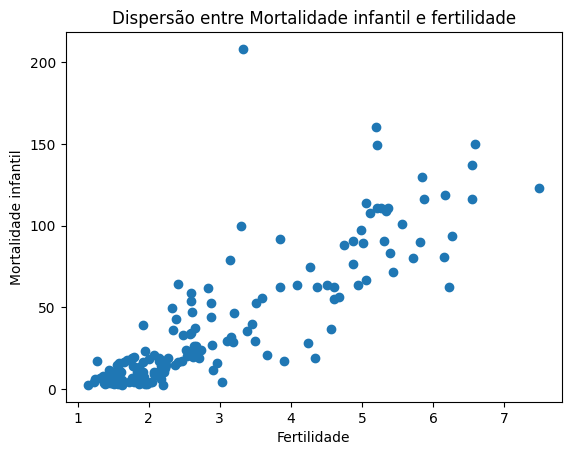

In [ ]:
scatter_df = data[[ 'total_fer', 'child_mort']]
plt.scatter(scatter_df.iloc[:, 0], scatter_df.iloc[:, 1])
plt.title('Dispersão entre Mortalidade infantil e fertilidade')
plt.xlabel("Fertilidade")
plt.ylabel("Mortalidade infantil")

Text(0, 0.5, 'Distância')

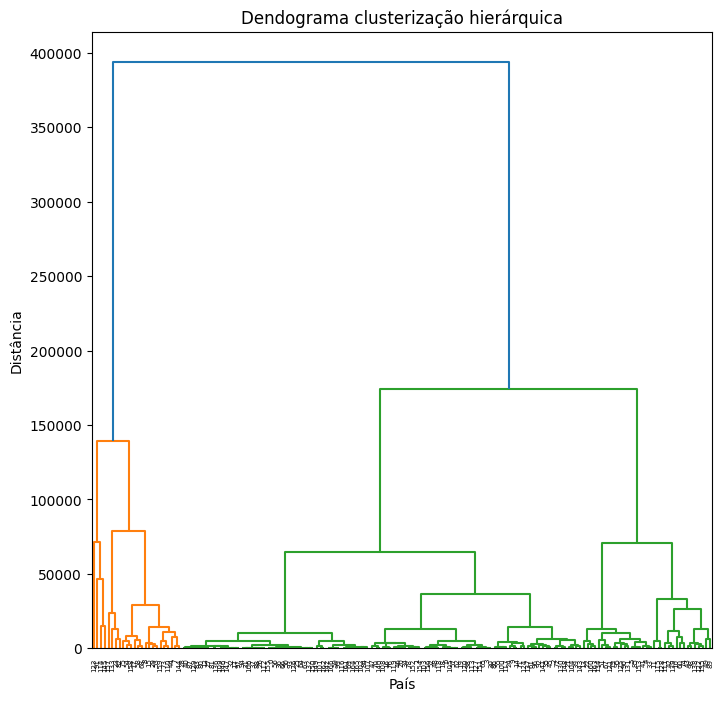

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

linkage = sch.linkage(data, method="ward")

dend = sch.dendrogram(linkage, get_leaves=True)
plt.title('Dendograma clusterização hierárquica')
plt.xlabel("País")
plt.ylabel("Distância")

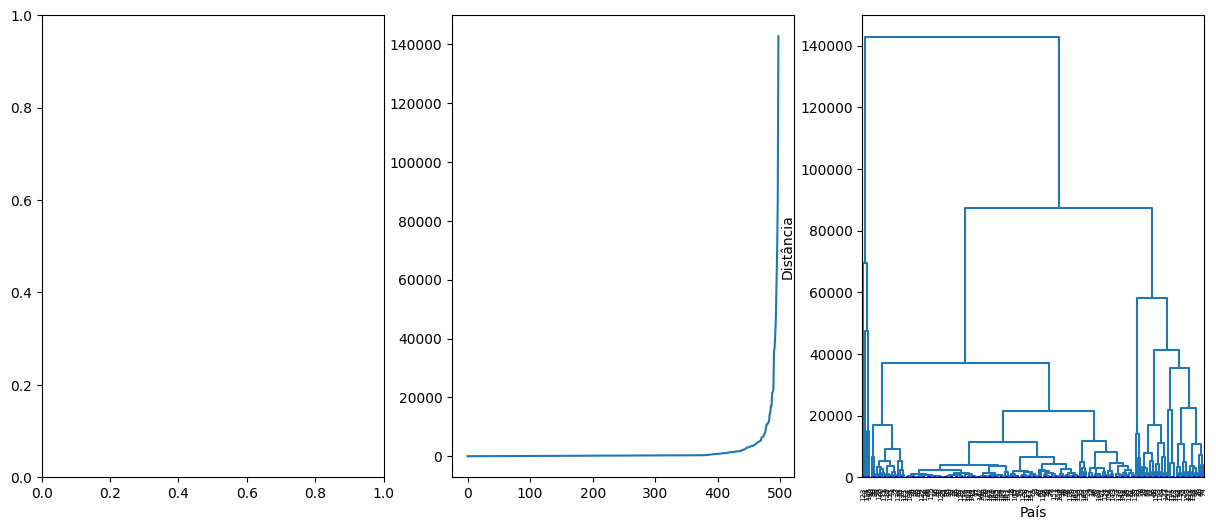

In [ ]:
distance_threshold = 75
linkage_method =  'complete'
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes[2]
linkage =  sch.linkage(data, method=linkage_method)
dend = sch.dendrogram(linkage, color_threshold=distance_threshold,
                      get_leaves=True);
ax.set_xlabel("País")
ax.set_ylabel("Distância")
ax.axhline(distance_threshold, c='blue', ls=":")
axes[1].plot(np.unique(linkage))
ax = axes[0]
model = AgglomerativeClustering(n_clusters=None,
                                linkage=linkage_method,
                                distance_threshold=distance_threshold)
clusters = model.fit(data)
labels = model.labels_

In [ ]:
output_rows = []
input = data
for index, (leave, cluster) in enumerate(zip(dend['leaves'], dend['leaves_color_list'])):
    output_row = {
        'Country': input.index[leave],
        'Child Mort': input.child_mort[leave],
        'Life Expec' : input.life_expec[leave],
        'Leave': leave,
        'Cluster': cluster
    }
    output_rows.append(output_row)

output_df = pd.DataFrame(output_rows)

cluster_counts = output_df['Cluster'].value_counts()

cluster_counts

C0    157
C1      2
C2      2
C3      2
C4      2
C5      2
Name: Cluster, dtype: int64

Os países estão mal distribuídos entre os 6 clusters que foram formados

# DBSCAN

O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clusterização que se destaca por sua capacidade de identificar clusters de formas arbitrárias e de lidar eficientemente com outliers. Opera com base na densidade dos pontos de dados em vez de assumir formas específicas de clusters. A principal característica do DBSCAN é sua capacidade de distinguir regiões densas de pontos daquelas menos densas, considerando a proximidade entre eles. O algoritmo define clusters como áreas densas de pontos que estão separadas por regiões menos densas.

O parâmetro eps especifica a distância máxima entre dois pontos para que um deles seja considerado como vizinho do outro. Pontos dentro da distância eps são considerados vizinhos e contribuem para a formação de um cluster. Se a distância entre dois pontos é menor ou igual a eps, eles são considerados parte do mesmo cluster. O parâmetro min_samples especifica o número mínimo de pontos necessários para formar um "ponto central" ou "ponto núcleo". Um ponto central é um ponto que tem pelo menos min_samples pontos em sua vizinhança (incluindo ele mesmo). Pontos que são centrais e estão dentro da distância eps uns dos outros formam um cluster. Pontos que não são centrais, mas estão dentro da vizinhança de um ponto central, são considerados pontos de borda.

Abaixo temos a distribuição para clusters encontrada

In [ ]:
df = pd.DataFrame(data_normal, columns=cols, index=data.index)
dbscan = DBSCAN(eps=1.3, min_samples=5)
df['cluster'] = dbscan.fit_predict(df)
df.cluster.value_counts().sort_index()

df[['cluster'] + cols].groupby(['cluster']).mean().T

cluster,-1,0,1
child_mort,0.354503,1.351321,-0.521773
exports,0.465804,-0.626882,-0.059947
health,0.027770,-0.397608,0.090237
imports,0.350099,-0.349762,-0.076672
income,0.409171,-0.789856,0.009631
inflation,0.483807,0.038179,-0.241766
life_expec,-0.304913,-1.255928,0.473169
total_fer,0.280054,1.591481,-0.548641
gdpp,0.283569,-0.667014,0.037825


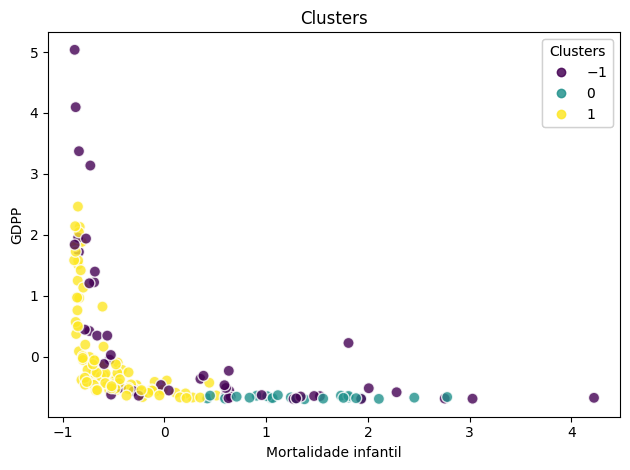

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Clusters")
ax.set_xlabel("Mortalidade infantil")
ax.set_ylabel("GDPP")
sc = ax.scatter(df.child_mort, df.gdpp, c=dbscan.labels_, cmap='viridis', edgecolors='white', s=64, alpha=0.8)
legend = ax.legend(*sc.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.tight_layout()
plt.show()

os clusters 0 e 1 estão relativamente bem separados, já o -1 está distribuido em demasia entre as variáveis.

In [ ]:
df[['child_mort', 'gdpp', 'cluster']][df['cluster'] == -1][:5]

,child_mort,gdpp,cluster
country,,,
Angola,2.007808,-0.516268,-1
Bahrain,-0.737914,0.423331,-1
Belgium,-0.839884,1.720274,-1
Botswana,0.353908,-0.361949,-1
Brunei,-0.690660,1.222291,-1


In [ ]:
df[['child_mort', 'gdpp', 'cluster']][df['cluster'] == 0][:5]

,child_mort,gdpp,cluster
country,,,
Afghanistan,1.291532,-0.679180,0
Benin,1.808842,-0.667961,0
Burkina Faso,1.933196,-0.677976,0
Burundi,1.376093,-0.696801,0
Cameroon,1.734230,-0.637754,0


In [ ]:
df[['child_mort', 'gdpp', 'cluster']][df['cluster'] == 1][:5]

,child_mort,gdpp,cluster
country,,,
Albania,-0.538949,-0.485623,1
Algeria,-0.272833,-0.465376,1
Antigua and Barbuda,-0.695634,-0.041817,1
Argentina,-0.591177,-0.145791,1
Armenia,-0.501643,-0.533233,1


o DBSCAN gerou três clusters diferentes. O cluster -1, com distribuição mais espalhada, representa outliers ou pontos de baixa densidade.

# Discussão da comparação entre os métodos

Podemos verificar que o K-Means é sensível a outliers, dado seu algoritmo baseado em agrupar os pontos em clusters esféricos de tamanhos aproximados, fazendo com que outliers distorçam o cálculo dos centróides. Isso ocorre porque a média, que é usada para calcular os centróides, é influenciada pelos valores extremos. Por outro lado, o DBSCAN é mais robusto na identificação de aglomerados, pois sua abordagem baseada em densidade permite lidar eficientemente com pontos isolados, considerando a distribuição global de densidade no conjunto de dados. Isso torna o DBSCAN uma escolha mais robusta em cenários onde a presença de outliers é uma preocupação.

In [ ]:
!pip